# split_dataset

In [ ]:
import os
import shutil
import random

input_dir = "C:/Users/pc/Documents/project machin learning/IMT/Datasets/1- KideyStone/dataset"
output_dir = "C:/Users/pc/Documents/project machin learning/IMT/Datasets/1- KideyStone/dataset_split"

def split_dataset(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    classes = os.listdir(input_dir)
    for cls in classes:
        class_path = os.path.join(input_dir, cls)
        images = os.listdir(class_path)
        random.shuffle(images)

        train_end = int(len(images)*train_ratio)
        val_end = train_end + int(len(images)*val_ratio)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split in splits:
            split_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in splits[split]:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(split_dir, img)
                shutil.copy(src_path, dst_path)

split_dataset(input_dir, output_dir)


# augmentation_pipeline

In [ ]:
from torchvision import transforms
from PIL import Image
import os
import shutil

train_dir = r"C:/Users/pc/Documents/project machin learning/IMT/Datasets/1- KideyStone/dataset_split/train"
augmented_dir = r"C:/Users/pc/Documents/project machin learning/IMT/Datasets/1- KideyStone/augmentation_train"

# Resize 
resize_transform = transforms.Resize((512, 512))

# Augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0)),
])

os.makedirs(augmented_dir, exist_ok=True)

classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# =========================================


for cls in classes:
    class_input_path = os.path.join(train_dir, cls)
    class_output_path = os.path.join(augmented_dir, cls)
    os.makedirs(class_output_path, exist_ok=True)

    for img_file in os.listdir(class_input_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            src = os.path.join(class_input_path, img_file)
            dst = os.path.join(class_output_path, img_file)
            shutil.copy(src, dst)  # 👈 اضافه شده

# =========================================

for cls in classes:
    class_input_path = os.path.join(train_dir, cls)
    class_output_path = os.path.join(augmented_dir, cls)

    images = [img for img in os.listdir(class_input_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    print(f"Processing class '{cls}' with {len(images)} images...")

    for idx, img_file in enumerate(images):
        img_path = os.path.join(class_input_path, img_file)
        image = Image.open(img_path).convert("RGB")

        # Resize ثابت 512x512
        image = resize_transform(image)

        for i in range(3):
            augmented_img = augmentation(image)
            save_path = os.path.join(class_output_path, f"{os.path.splitext(img_file)[0]}_aug{i+1}.jpg")
            augmented_img.save(save_path)

print(" Augmentation Images Done.")

In [52]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [53]:
# (CPU or GPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [54]:
train_dir = r"C:/Users/pc/Documents/project machin learning/IMT/Datasets/1- KideyStone/augmentation_train"
val_dir =  r"C:/Users/pc/Documents/project machin learning/IMT/Datasets/1- KideyStone/dataset_split/val"
test_dir =  r"C:/Users/pc/Documents/project machin learning/IMT\Datasets/1- KideyStone/dataset_split/test"

In [56]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}


In [57]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
}

In [ ]:
dataLoaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x=='train'))
    for x in ['train', 'val', 'test']
}


class_name = image_datasets['train'].classes
print(f"Classes: {class_name}")

Classes: ['Normal', 'stone']


In [ ]:
model = models.resnet18(pretrained=True)

# فریز کردن همه‌ی لایه‌ها
for param in model.parameters():
    param.requires_grad = False

# fully connected 
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)


In [60]:
class_weights = [2.0, 1.0] # کلاس Normal (کلاس 0) وزن بیشتری دارد
weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


In [61]:
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)



In [62]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0  

        for inputs, labels in dataLoaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")



Epoch 1/10
train Loss: 0.2953 Acc: 0.8706
val Loss: 0.1200 Acc: 0.9719

Epoch 2/10
train Loss: 0.1637 Acc: 0.9327
val Loss: 0.0782 Acc: 0.9792

Epoch 3/10
train Loss: 0.1355 Acc: 0.9452
val Loss: 0.0602 Acc: 0.9854

Epoch 4/10
train Loss: 0.1212 Acc: 0.9502
val Loss: 0.0482 Acc: 0.9861

Epoch 5/10
train Loss: 0.1111 Acc: 0.9535
val Loss: 0.0427 Acc: 0.9900

Epoch 6/10
train Loss: 0.1062 Acc: 0.9567
val Loss: 0.0385 Acc: 0.9900

Epoch 7/10
train Loss: 0.1020 Acc: 0.9571
val Loss: 0.0347 Acc: 0.9927

Epoch 8/10
train Loss: 0.0955 Acc: 0.9604
val Loss: 0.0321 Acc: 0.9927

Epoch 9/10
train Loss: 0.0973 Acc: 0.9602
val Loss: 0.0311 Acc: 0.9923

Epoch 10/10
train Loss: 0.0908 Acc: 0.9627
val Loss: 0.0324 Acc: 0.9908



Confusion Matrix:
[[1206   10]
 [  20 1380]]

Classification Report:
              precision    recall  f1-score   support

      Normal      0.984     0.992     0.988      1216
       stone      0.993     0.986     0.989      1400

    accuracy                          0.989      2616
   macro avg      0.988     0.989     0.988      2616
weighted avg      0.989     0.989     0.989      2616



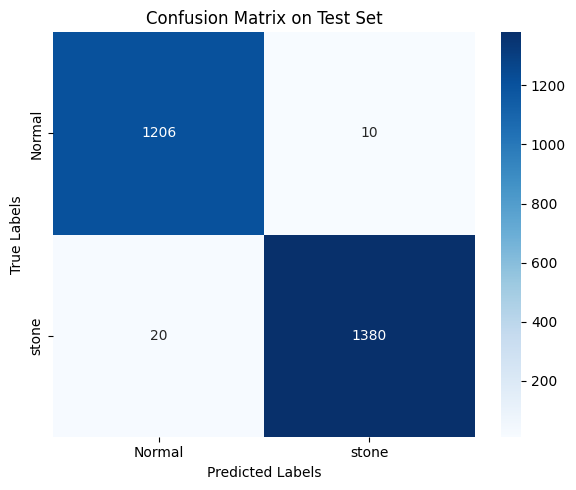

In [ ]:
# ==========================
#  final eval test
# ==========================

model.eval()  
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataLoaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#   Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

#   Classification Report (شامل) Precision، Recall، F1)
report = classification_report(all_labels, all_preds, target_names=class_name, digits=3)
print("\nClassification Report:")
print(report)

#   Confusion Matrix 
import seaborn as sns
import numpy as np

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()
